# 1. Basic Wolfram Language Integration with Python

Continuation of Wolfram Language™ for Python users. This notebook contains examples of:

- generating and executing Wolfram Language code
- accessing the Wolfram Knowledgebase™ 
- communication between languages

## Generating Wolfram Language Code

All named Wolfram expressions (symbols, functions) can be represented in Python using the **wl.** header:

In [1]:
from wolframclient.language import wl, wlexpr
x = wl.Select(wl.Range(10), wl.PrimeQ)
y = wl.Reverse(wl.Range(10))
z = wl.Now
print(x)
print(y)
print(z)

Select[Range[10], PrimeQ]
Reverse[Range[10]]
Now


**wl.expr** can be used to represent all unnamed Wolfram expressions:

In [2]:
wl.Map(wlexpr('#^2&'), [1,2,3])

Map[(#^2&), [1, 2, 3]]

The syntax of Wolfram Language functions must be modified to work with Python. For example:

Function[arg1, arg2, Option->OptionValue] becomes wl.Function(arg1, arg2, Option=OptionValue).

## Evaluating Wolfram Language Code

Wolfram expressions generated inside Python will not evaluate unless called explicitly. One way to achieve this is with local kernel evaluation, which utilises the wolfram kernel licences contained within a Wolfram product installation such as Mathematica®. This is achieved with **session.evaluate** imported from the **WolframLanguageSession** library:

In [3]:
from wolframclient.evaluation import WolframLanguageSession
session = WolframLanguageSession()

session.evaluate(x)

PackedArray([2, 3, 5, 7], dtype=int8)

In [4]:
session.evaluate(y)

PackedArray([10,  9,  8,  7,  6,  5,  4,  3,  2,  1], dtype=int8)

In [5]:
session.evaluate(z)

DateObject[(2021, 4, 14, 13, 38, Decimal('8.7897631')), 'Instant', 'Gregorian', 1.0]

**Data Conversion**

As shown above, some simple data types (lists, integers) are automatically converted into Python formats. Others, such as DateObject and Graphics, will remain as Wolfram Language expression types and will need to be serialised (see section 2), manually converted or exported/rendered:

In [6]:
data = [.3, 2, 4, 5, 5.5]
graphic = wl.BarChart(data, ChartLabels=["a", "b", "c", "d", "e"])
path = "/tmp/barchart1.png"
png_export = wl.Export(path, graphic, "PNG")
session.evaluate(png_export)

'/tmp/barchart1.png'

Some data types can be converted between Python and Wolfram Language once a relevant library is loaded. For example: PIL or iPython images can be used as image inputs for Wolfram Language functions:

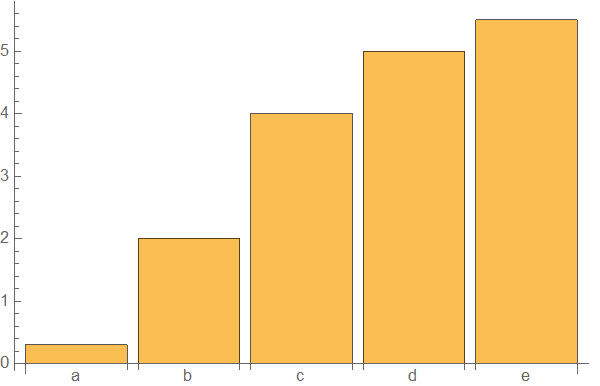

In [7]:
from PIL import Image
barchartImage = Image.open('/tmp/barchart1.png')
barchartImage

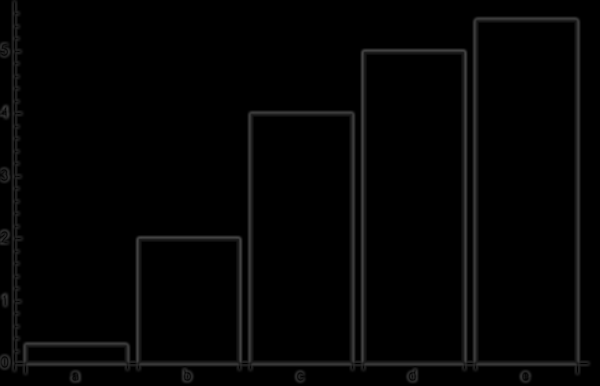

In [8]:
png_export2 = wl.Export("/tmp/barchart2.png", wl.GradientFilter(barchartImage, 3), "PNG")
session.evaluate(png_export2)
Image.open('/tmp/barchart2.png')

## Defining Functions

In addition to symbol definition, Python functions can be defined using Wolfram Language components. This can be achieved either by defining the function using Python syntax and wl headers, or by using **session function** to read a pre-defined function within the Wolfram kernel. 
 
**Example:** Define a function to return the population density as a fraction of people to country area in people/miles^2.

**Method 1: using wl headers:**

In [9]:
def population_density(country):
    return(session.evaluate(
        wl.QuantityMagnitude(
            wl.Divide(
                wl.EntityValue(wl.Entity("Country", country), "Population"),
                wl.EntityValue(wl.Entity("Country", country), "Area")
            )
        )
  ))

In [10]:
population_density("France")

305.86623557458205

**Method 2: using a string wlexpression and session function:**

First evaluate a wl function definition:

In [11]:
session.evaluate(wlexpr('''
    populationDensity[country_String] := QuantityMagnitude[
        Divide[
            EntityValue[Entity["Country", country], "Population"],
            EntityValue[Entity["Country", country], "Area"]
        ]
    ];
'''))

Then call this definition using session.function:

In [12]:
population_density2 = session.function(wlexpr('populationDensity'))

In [13]:
population_density2("France")

305.86623557458205

Alternatively, using the Global environment:

In [14]:
from wolframclient.language import Global
population_density3 = session.function(Global.populationDensity)
population_density3("France")

305.86623557458205

## Sessions

**Note:** Sessions are equivalent to Wolfram kernels and if not properly terminated will form orphaned kernels. Aim to maintain only a single session within Python and terminate it at the end of every session.

To terminate a session, use session.terminate():

In [15]:
session.terminate()

Alternatively, a session can be handled locally with a With block:

In [16]:
with WolframLanguageSession() as wl_blocksession:
    print(wl_blocksession.evaluate(wl.StringReverse('abc')))

cba
